<a href="https://colab.research.google.com/github/tishasharma07/Covid_Detection/blob/main/Covid_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir -p ~/ .kaggle/

! mv /content/kaggle.json ~/ .kaggle/

! chmod 600 /.kaggle/kaggle.json
#!/bin/bash
! kaggle datasets download sid321axn/covid-cxr-image-dataset-research

mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research
License(s): CC0-1.0
100% 572M/572M [00:30<00:00, 21.0MB/s]
100% 572M/572M [00:30<00:00, 19.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
dataset_zip="/content/covid-cxr-image-dataset-research.zip"
if os.path.exists(dataset_zip):
  with zipfile.ZipFile(dataset_zip,'r') as zip_ref:
    zip_ref.extractall('covid-cxr-image-dataset-research')

In [ ]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
os.listdir("/content/covid-cxr-image-dataset-research/COVID_IEEE")

['covid', 'normal', 'virus']

In [ ]:
len(os.listdir("/content/covid-cxr-image-dataset-research/COVID_IEEE/normal"))

668

In [ ]:
len(os.listdir("/content/covid-cxr-image-dataset-research/COVID_IEEE/virus"))

619

In [ ]:
len(os.listdir("/content/covid-cxr-image-dataset-research/COVID_IEEE/covid"))

536

In [ ]:
dataset_dir="/content/covid-cxr-image-dataset-research/COVID_IEEE"
class_dirs=['normal', 'virus', 'covid']
#print overview info
print("Dataset Overview")
print("===================")

for class_dir in class_dirs:
  class_path= os.path.join(dataset_dir,class_dir)
  num_images= len(os.listdir(class_path))
  print(f"Class: {class_dir},Number of images: {num_images}")

  total_images=sum(len(os.listdir(os.path.join(dataset_dir,class_dir))) for class_dir in class_dirs)
  print(f"Total number of Images in Dataset:{total_images}")

Dataset Overview
Class: normal,Number of images: 668
Total number of Images in Dataset:1823
Class: virus,Number of images: 619
Total number of Images in Dataset:1823
Class: covid,Number of images: 536
Total number of Images in Dataset:1823


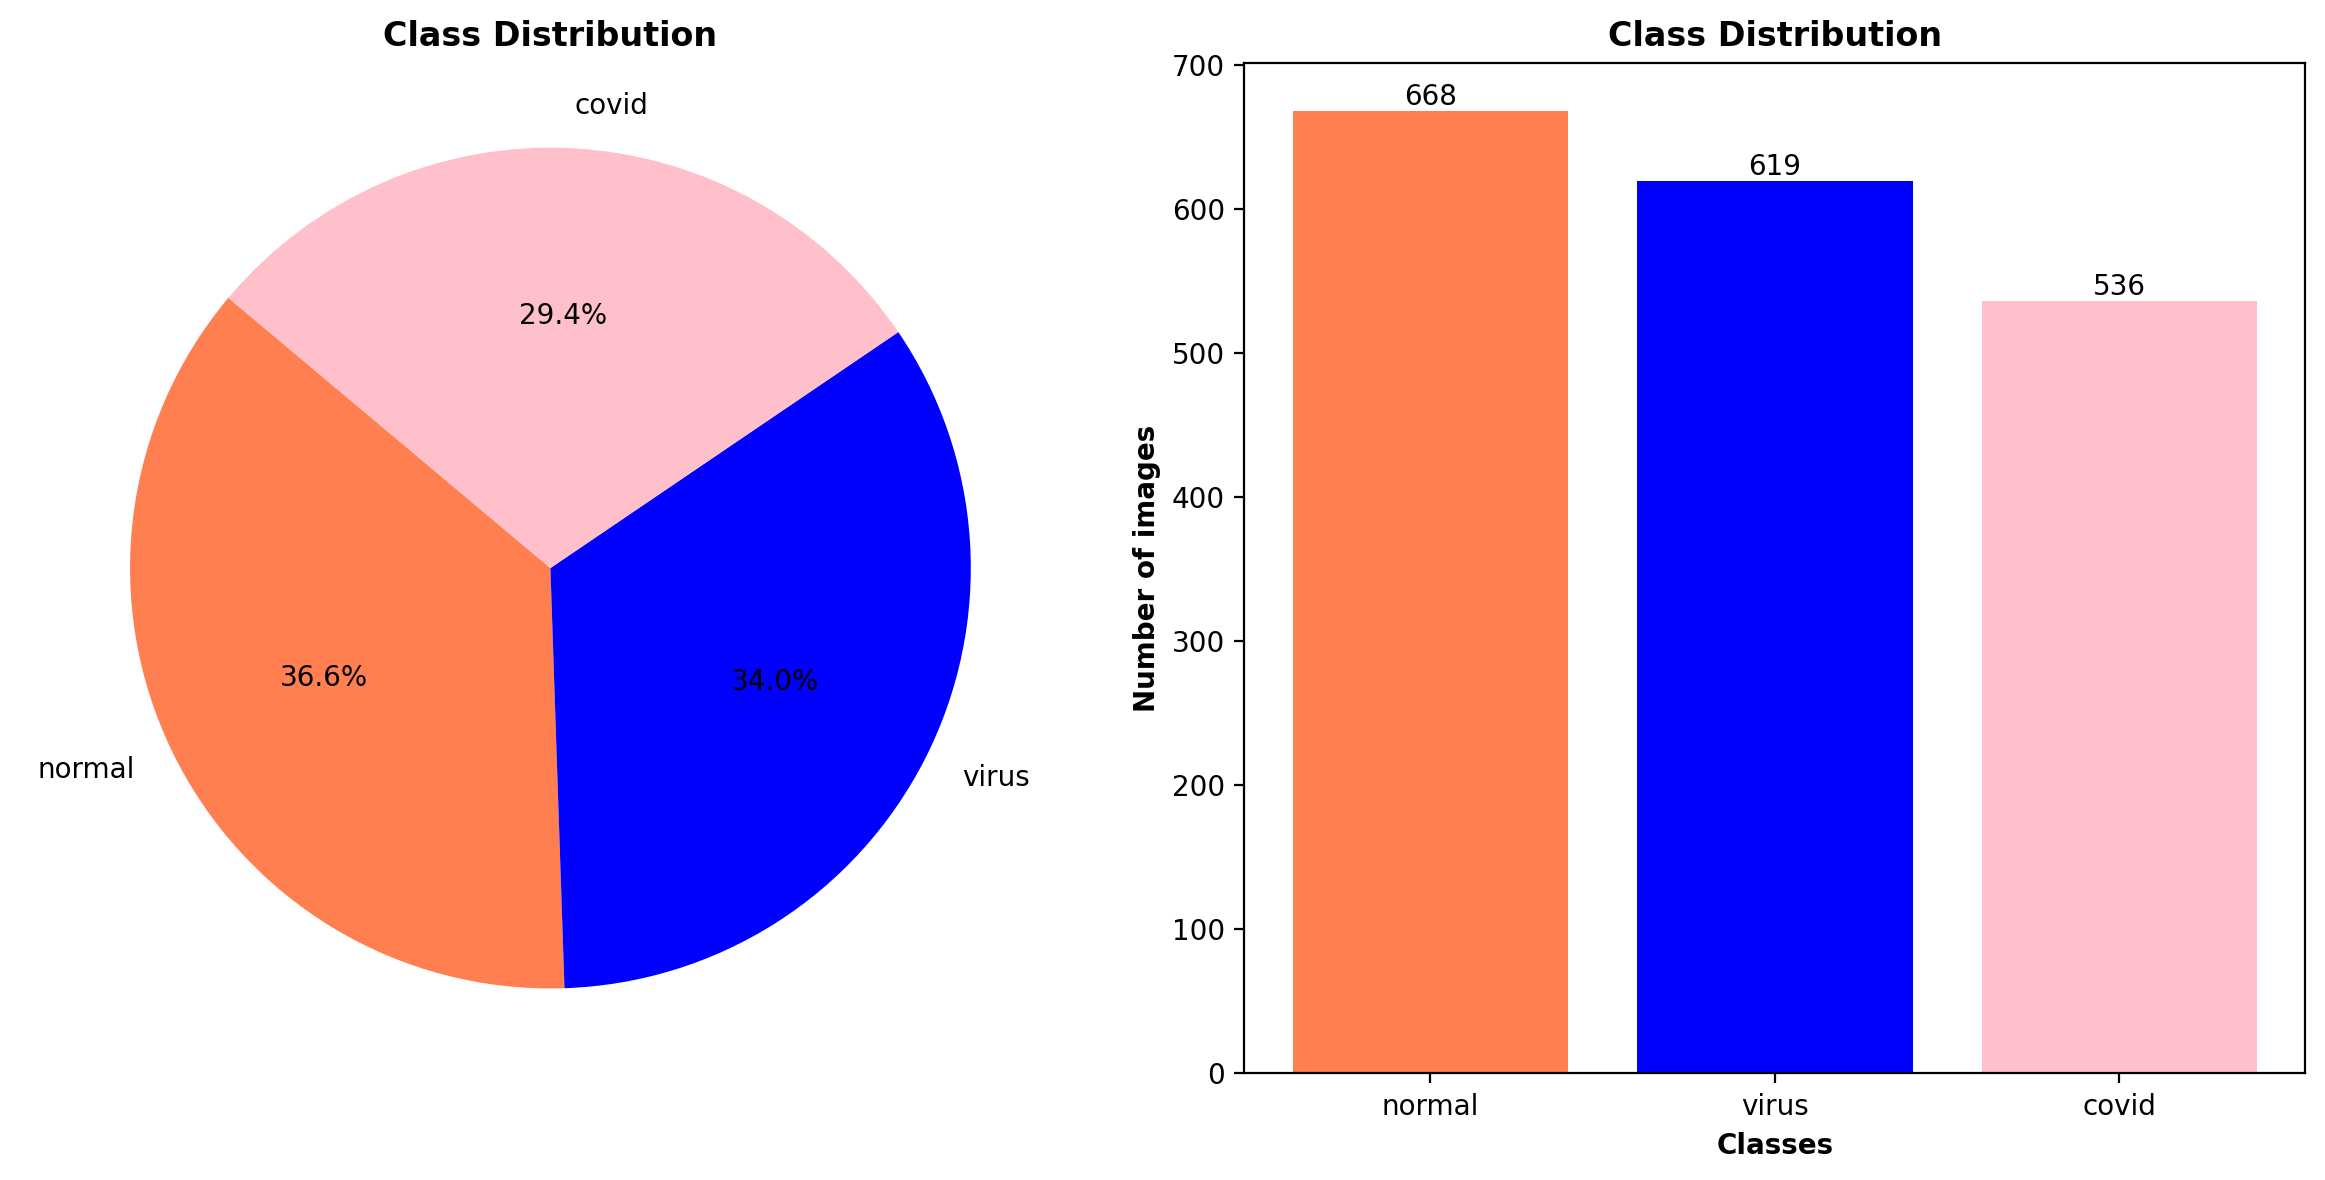

In [ ]:
class_counts = [len(os.listdir(os.path.join(dataset_dir, class_dir))) for class_dir in class_dirs]
percentages= [(count/sum(class_counts)) * 100 for count in class_counts]

fig, (ax1,ax2 ) = plt.subplots(1,2, figsize=(12,6), dpi=200)

#colours
colors=['coral','blue','pink']

#pie chart
ax1.pie(percentages, labels =class_dirs, autopct='%1.1f%%', startangle=140, colors=colors)
ax1.set_title('Class Distribution',fontweight='bold' )
ax1.axis('equal')
#bar plot
bars=ax2.bar(class_dirs,class_counts,color=colors)
ax2.set_title('Class Distribution',fontweight="bold")
ax2.set_xlabel("Classes",fontweight="bold")
ax2.set_ylabel("Number of images",fontweight="bold")
# adding values on top of bars
for bar,count in zip(bars,class_counts):
  yval=bar.get_height()
  ax2.text(bar.get_x()+bar.get_width()/2,yval,count,ha="center",va="bottom",fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import random

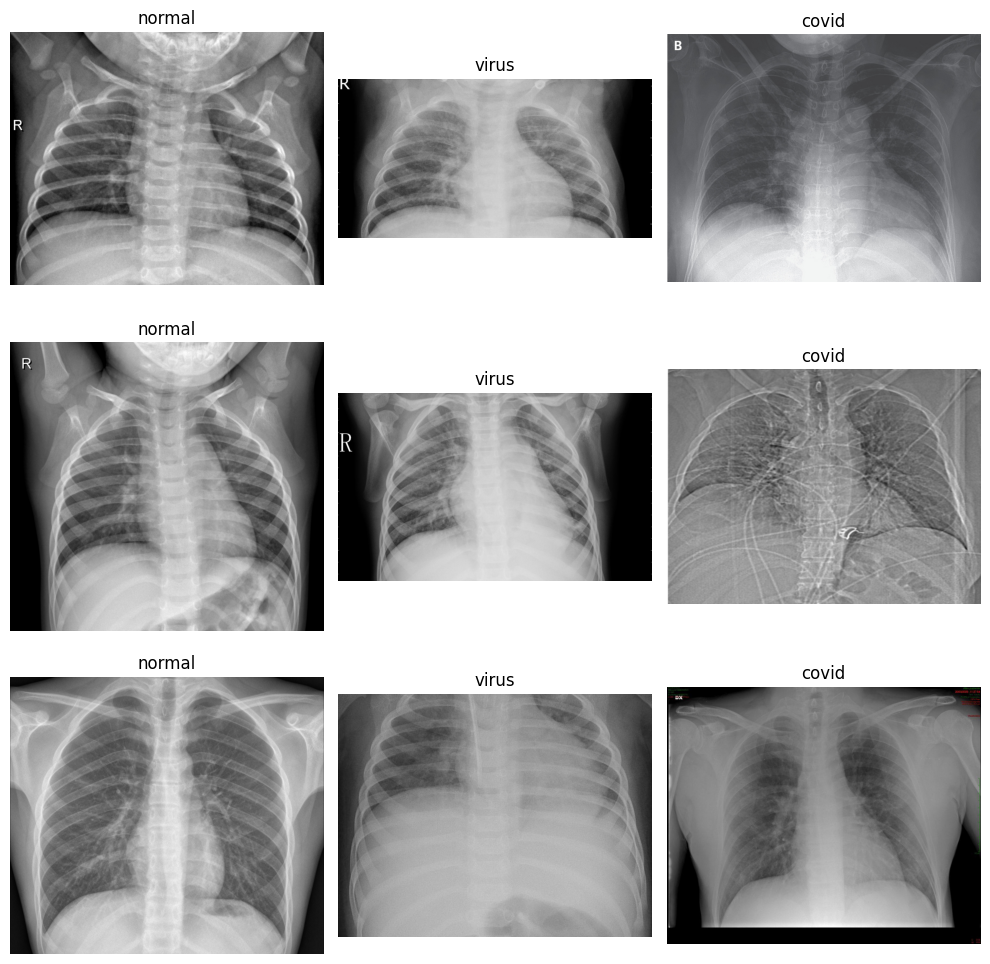

In [ ]:
def show_sample_images(dataset_dir, class_names, num_images=3):
    plt.figure(figsize=(10, 10))
    classes_shown = {class_name: 0 for class_name in class_names}
    i = 0

    while any(v < num_images for v in classes_shown.values()):
        for class_name in class_names:
            class_path = os.path.join(dataset_dir, class_name)
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

            if len(image_files) == 0:
                print(f"No images found in {class_name} directory.")
                continue

            # Select random image
            if classes_shown[class_name] < num_images:
                img_file = random.choice(image_files)
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)

                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
                    plt.subplot(3, 3, i + 1)
                    plt.imshow(img)
                    plt.title(class_name)
                    plt.axis("off")
                    i += 1
                    classes_shown[class_name] += 1

                if i >= 9:
                    break

    plt.tight_layout()
    plt.show()

# Show images from dataset
dataset_dir = "/content/covid-cxr-image-dataset-research/COVID_IEEE"
class_dirs = ['normal', 'virus', 'covid']

show_sample_images(dataset_dir, class_dirs)

In [ ]:
import shutil

In [ ]:
dataset_dir = "/content/covid-cxr-image-dataset-research/COVID_IEEE"
output_dir = "/content/splitted_dataset"

# Define class directories
class_dirs = ['normal', 'virus', 'covid']

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create output directories
for split in ['train', 'val', 'test']:
    for class_dir in class_dirs:
        os.makedirs(os.path.join(output_dir, split, class_dir), exist_ok=True)

# Function to split and copy data
def split_and_copy(class_name):
    class_path = os.path.join(dataset_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Shuffle the images for randomness
    random.shuffle(images)

    # Split into train (80%) and temp (20%)
    train_images, temp_images = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)

    # Split temp into validation (10%) and test (10%)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Function to move files
    def move_files(image_list, split_type):
        for img in image_list:
            src_path = os.path.join(class_path, img)
            dst_path = os.path.join(output_dir, split_type, class_name, img)
            shutil.copy(src_path, dst_path)  # Copy instead of move to keep the original dataset

    # Move files to respective directories
    move_files(train_images, 'train')
    move_files(val_images, 'val')
    move_files(test_images, 'test')

    print(f"{class_name}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

# Apply function to each class
for class_name in class_dirs:
    split_and_copy(class_name)

print("Dataset successfully split and saved in:", output_dir)

normal: 534 train, 67 val, 67 test
virus: 495 train, 62 val, 62 test
covid: 336 train, 42 val, 43 test
Dataset successfully split and saved in: /content/splitted_dataset


In [ ]:
img_size = (224, 224)
batch_size = 32

# Data Augmentation + Rescale
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
     brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Training Data
train_generator = datagen.flow_from_directory(
    "/content/splitted_dataset/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

# Validation Data
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/splitted_dataset/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)
# Test Data Generator
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/splitted_dataset/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


Found 1365 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Found 172 images belonging to 3 classes.


In [ ]:

# CNN Model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(224, 224, 1), padding="same", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dense(3, activation="softmax"))
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=50,
#     callbacks=[early_stopping],
#     verbose=1
# )
# model.save("Model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 3, 3, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             1

 Total params: 2,398,787 (9.15 MB)

 Trainable params: 2,398,659 (9.15 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)
model.save("Model.h5")
# Training & Validation Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 757ms/step - accuracy: 0.4280 - loss: 2.0566 - val_accuracy: 0.5556 - val_loss: 2.0429
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.7155 - loss: 1.5903 - val_accuracy: 0.5731 - val_loss: 1.9502
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.8042 - loss: 1.4031 - val_accuracy: 0.6491 - val_loss: 1.8785
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - accuracy: 0.8415 - loss: 1.2883 - val_accuracy: 0.7485 - val_loss: 1.7696
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.8759 - loss: 1.2049 - val_accuracy: 0.7895 - val_loss: 1.7013
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.8792 - loss: 1.1400 - val_accuracy: 0.8070 - val_loss: 1.5758
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9099 - loss: 1.0770 - val_accuracy: 0.8480 - val_loss: 1.4867
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.9181 - loss: 1.0209 - val_accu

Training Accuracy: 95.75%
Validation Accuracy: 95.91%


In [ ]:
from keras.models import load_model
loaded_model=load_model("Model.h5")

In [ ]:
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.9788 - loss: 0.5579
Test Accuracy: 97.67%


In [ ]:
# # Training & Validation Accuracy
# train_acc = history.history['accuracy'][-1]
# val_acc = history.history['val_accuracy'][-1]

# print(f"Training Accuracy: {train_acc * 100:.2f}%")
# print(f"Validation Accuracy: {val_acc * 100:.2f}%")

In [ ]:


# # Evaluate Model
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_acc * 100:.2f}%")


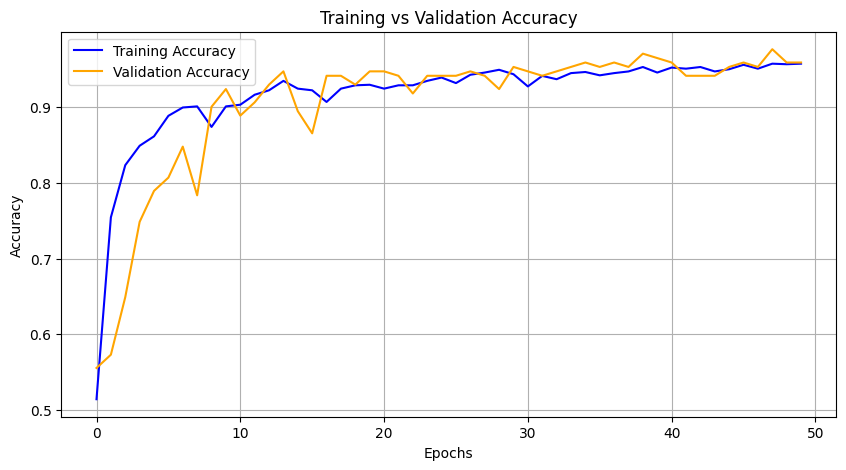

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

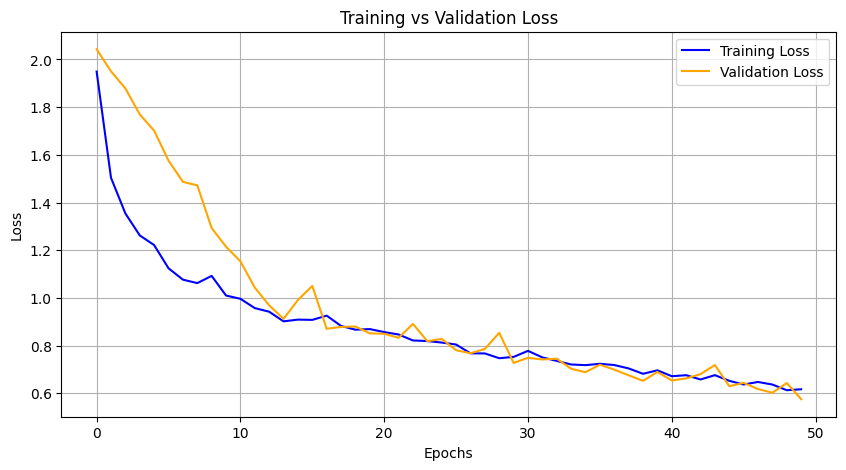

In [ ]:
# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Step 1: Predictions
# y_pred = model.predict(val_generator)
# y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels
# y_true = val_generator.classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step


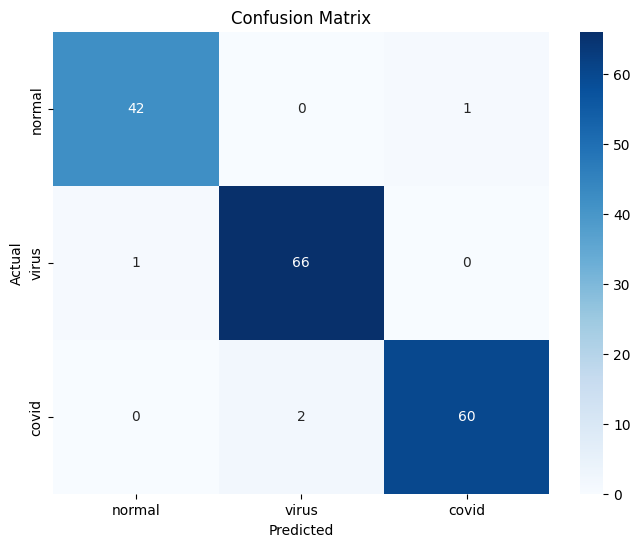

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels
y_true = test_generator.classes

# Step 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_dirs, yticklabels=class_dirs)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [ ]:
# Step 3: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_dirs))


Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98        43
       virus       0.97      0.99      0.98        67
       covid       0.98      0.97      0.98        62

    accuracy                           0.98       172
   macro avg       0.98      0.98      0.98       172
weighted avg       0.98      0.98      0.98       172



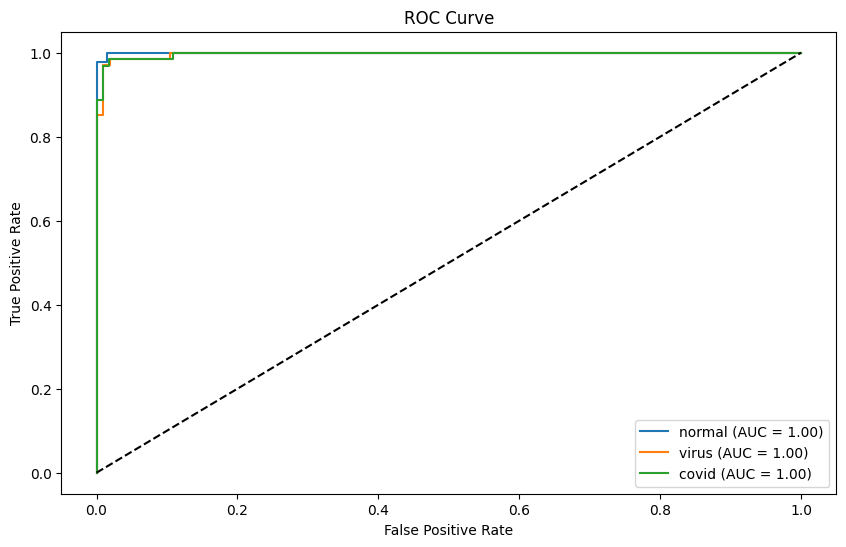

In [ ]:
# Step 4: ROC Curve
plt.figure(figsize=(10, 6))

for i in range(3):  # For each class
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_dirs[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"🔹 Accuracy: {accuracy * 100:.2f}%")

# Precision
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f"🔹 Precision: {precision * 100:.2f}%")

# Recall
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f"🔹 Recall: {recall * 100:.2f}%")

# F1-Score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"🔹 F1 Score: {f1 * 100:.2f}%")


🔹 Accuracy: 97.67%
🔹 Precision: 97.68%
🔹 Recall: 97.67%
🔹 F1 Score: 97.67%


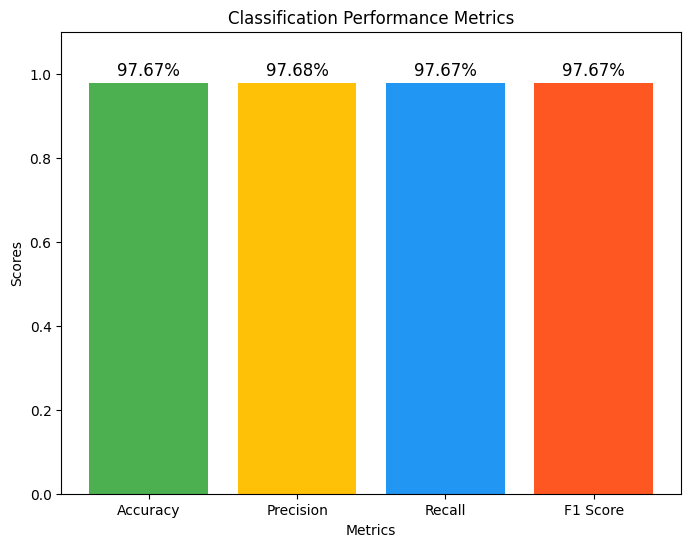

In [ ]:
# List of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['#4CAF50', '#FFC107', '#2196F3', '#FF5722'])

# Displaying values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value * 100:.2f}%', ha='center', fontsize=12)

# Setting plot labels and title
plt.ylim(0, 1.1)  # To make sure the labels fit above the bars
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Classification Performance Metrics')

# Show the plot
plt.show()

In [ ]:
# from sklearn.metrics import (cohen_kappa_score, matthews_corrcoef,
#                              mean_absolute_error, mean_squared_error, r2_score)


In [ ]:
# # 1. Cohen Kappa Score (classification)
# kappa = cohen_kappa_score(y_true, y_pred_classes)
# print(f"Cohen Kappa Score: {kappa:.4f}")

# # 2. Matthews Correlation Coefficient (classification)
# mcc = matthews_corrcoef(y_true, y_pred_classes)
# print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# # 3. Mean Absolute Error (using class labels as numeric values)
# mae = mean_absolute_error(y_true, y_pred_classes)
# print(f"Mean Absolute Error: {mae:.4f}")

# # 4. Mean Squared Error
# mse = mean_squared_error(y_true, y_pred_classes)
# print(f"Mean Squared Error: {mse:.4f}")

# # 5. R2 Score
# r2 = r2_score(y_true, y_pred_classes)
# print(f"R2 Score: {r2:.4f}")